In [2]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score
from pathlib import Path
import matplotlib.pyplot as plt
import random
import pandas as pd
from matplotlib import colormaps
import torch.nn.functional as F


import zennit.composites
import zennit.rules
import zennit.core
import zennit.attribution
from zennit.types import Linear

from zennit.composites import LayerMapComposite
from zennit.rules import Epsilon, ZPlus, Pass


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# ------------------------
# 1️⃣ Custom Dataset Class
# ------------------------
class VibrationDataset(Dataset):
    def __init__(self, data_dir):
        self.file_paths = []
        self.labels = []

        for label, label_idx in zip(["good", "bad"], [0, 1]):  # 0=good, 1=bad
            folder = Path(data_dir) / label
            for file_name in os.listdir(folder):
                if file_name.endswith(".h5"):
                    self.file_paths.append(os.path.join(folder, file_name))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, "r") as f:
            data = f["vibration_data"][:]  # Shape (10000, 3)

        data = np.transpose(data, (1, 0))  # Change to (3, 10000) for CNN
        label = self.labels[idx]

        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [5]:
# ------------------------
# 2️⃣ Define the CNN Model
# ------------------------
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 1250, 256)  # Flattened size: (64, 1250)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification (good/bad)

        self.dropout = nn.Dropout(0.3)  # Reduce overfitting
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.shape[0], -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (we use CrossEntropyLoss)

        return x


In [6]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(data_dir, batch_size=32, epochs=20, lr=0.001, train_ratio=0.7, val_ratio=0.15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [7]:
# ------------------------
# 3️⃣ Train & Evaluate Functions
# ------------------------
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), accuracy


In [8]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [9]:
# ------------------------
# 4️⃣ Test the Model
# ------------------------
def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    return f1, accuracy


In [10]:
# Splitting the dataset
data_directory = "./data/final/Selected_data_windowed_grouped_normalized"

dataset = VibrationDataset(data_directory)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(train_loader, val_loader, test_loader, epochs=20, lr=0.001):

    '''
        # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    '''

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [12]:
# ------------------------
# 6️⃣ Run Training & Evaluation
# ------------------------
model = train_and_evaluate(train_loader, val_loader, test_loader)


Epoch [1/20] - Train Loss: 3.4882, Train Acc: 0.6813 - Val Loss: 0.3792, Val Acc: 0.8447
Epoch [2/20] - Train Loss: 0.6178, Train Acc: 0.8417 - Val Loss: 0.2226, Val Acc: 0.9320
Epoch [3/20] - Train Loss: 0.3156, Train Acc: 0.8958 - Val Loss: 0.1831, Val Acc: 0.9515
Epoch [4/20] - Train Loss: 0.1411, Train Acc: 0.9458 - Val Loss: 0.1084, Val Acc: 0.9417
Epoch [5/20] - Train Loss: 0.0873, Train Acc: 0.9708 - Val Loss: 0.1302, Val Acc: 0.9612
Epoch [6/20] - Train Loss: 0.0709, Train Acc: 0.9729 - Val Loss: 0.0829, Val Acc: 0.9709
Epoch [7/20] - Train Loss: 0.0467, Train Acc: 0.9833 - Val Loss: 0.1450, Val Acc: 0.9612
Epoch [8/20] - Train Loss: 0.0480, Train Acc: 0.9792 - Val Loss: 0.0614, Val Acc: 0.9612
Epoch [9/20] - Train Loss: 0.0372, Train Acc: 0.9854 - Val Loss: 0.1882, Val Acc: 0.9515
Epoch [10/20] - Train Loss: 0.0973, Train Acc: 0.9583 - Val Loss: 0.0429, Val Acc: 0.9612
Epoch [11/20] - Train Loss: 0.0336, Train Acc: 0.9854 - Val Loss: 0.0815, Val Acc: 0.9709
Epoch [12/20] - Tra

In [13]:
# Save the trained model
torch.save(model.state_dict(), "cnn1d_model.ckpt")
print("✅ Model saved to cnn1d_model.ckpt")


✅ Model saved to cnn1d_model.ckpt


In [14]:

model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")


✅ Model loaded and ready for explanations


In [138]:
#    Performs a single prediction on input data using the model.
def predict_single(model, x, detach=False):
    """
    Perform a single prediction on input data using the model.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        detach: If True, detach the tensor to avoid retaining the computational graph.
    Returns:
        prediction: Model output logits (before softmax).
        ypred: Predicted class label (0 or 1).
    """
    prediction = model.forward(x.unsqueeze(0)).to(device)  # Add batch dimension
    prediction = prediction[0]  # Remove batch dimension

    if detach:
        prediction = prediction.detach()

    ypred = torch.argmax(prediction).item()  # Predicted class

    return prediction, ypred


In [139]:
def visualize_combined_with_label_attribution(signal, attributions, label, method_name, cmap="bwr"):
    """
    Visualize signal with relevance heatmap and relevance over time in a 3x2 grid,
    including the label and average attribution for each axis over time.
    Args:
        signal: Original input signal (shape: (3, time_steps)).
        attributions: Importance values for explanation (shape: (3, time_steps)).
        label: True label for the sample (e.g., "Good" or "Bad").
        method_name: Name of the explanation method (e.g., "Integrated Gradients").
        cmap: Colormap for relevance (default: "bwr").
    """
    def calculate_average_attribution(attributions):
        """
        Calculate the average attribution for each axis.
        Args:
            attributions: Attribution values (shape: (3, time_steps)).
        Returns:
            A list of average attribution values for each axis.
        """
        averages = [np.mean(attr) for attr in attributions]
        return averages

    if isinstance(attributions, torch.Tensor):
        attributions = attributions.detach().cpu().numpy()

    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()

    # Calculate average attribution for each axis
    avg_attributions = calculate_average_attribution(attributions)

    axes_labels = ["X", "Y", "Z"]
    fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns
    label_text = f"Label: {'Good' if label == 0 else 'Bad'}"



    for i in range(3):  # Loop over axes: X, Y, Z
        time_steps = np.arange(signal[i].shape[0])


        # Find the maximum absolute value for the current axis
        max_abs_value = np.max(np.abs(attributions[i]))
        print(f" Maximum Absolute Attribution in Axis {i}: {max_abs_value}")

        # Map attributions to colors using bwr colormap, scaling between -max_abs_value and +max_abs_value
        norm = plt.Normalize(vmin=-max_abs_value, vmax=max_abs_value)
        cmap = colormaps['bwr']

        # Normalize using -max_abs_value to +max_abs_value to keep zero as white
        '''relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] + max_abs_value) / (2 * max_abs_value))



        # Left column: Signal + Relevance Heatmap
        relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] - np.min(attributions[i])) /
                                                 (np.max(attributions[i]) - np.min(attributions[i])))  # Map to colormap'''

        for t in range(len(time_steps) - 1):
            axs[i, 0].axvspan(time_steps[t], time_steps[t + 1],  color=cmap(norm(attributions[i][t])), alpha=0.5)

        axs[i, 0].plot(time_steps, signal[i], color="black", linewidth=0.8, label="Signal")  # Thinner signal line
        axs[i, 0].set_title(f"{method_name} Heatmap for {axes_labels[i]}-Axis\n{label_text}, Average Attribution{avg_attributions[i]:.4f}")
        axs[i, 0].set_xlabel("Time Steps")
        axs[i, 0].set_ylabel("Signal Value")
        axs[i, 0].legend()

        # Right column: Relevance over Time
        axs[i, 1].bar(time_steps, attributions[i], color=["red" if val > 0 else "blue" for val in attributions[i]],
                      alpha=0.8, width=1.0)
        axs[i, 1].set_title(f"{method_name} Relevance Over Time for {axes_labels[i]}-Axis\n{label_text}")
        axs[i, 1].set_xlabel("Time Steps")
        axs[i, 1].set_ylabel("Relevance Value")

    fig.suptitle(f"Explanation for {method_name} - {label_text}", fontsize=16)  # Add overall title with label
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


In [140]:
def xai_gradient(model, x, target=None):
    """
    Compute gradients for the given input and target.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
    Returns:
        grad: Gradients w.r.t. input.
        target: Target class used for gradient computation.
    """
    x.requires_grad = True  # Enable gradient computation

    y_pred, y = predict_single(model, x)
    if target is None:
        target = y

    # Compute gradients
    grad, = torch.autograd.grad(y_pred[target], x, y_pred[target])
    # WHICH IS EQUIVALENT TO: y_pred[target].backward(y_pred[target]),  grad = x.grad

    return grad, target


In [141]:
def xai_grad_times_input(model, x, target=None):
    """
    Compute Grad*Input explanation for the given input.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
    Returns:
        attribution: Grad*Input attributions.
    """
    grad, target = xai_gradient(model, x, target)

    return grad * x, target  # Multiply gradients by input


In [19]:
def xai_smoothgrad(model, x, num_samples=200, noise_level=3, target=None):
    """
    Compute SmoothGrad explanation for the given input.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        num_samples: Number of noisy samples to generate (default: 200).
        noise_level: Standard deviation of added noise (default: 3).
        target: Target class for explanation (default: model's prediction).
    Returns:
        sgrad: SmoothGrad attributions (averaged gradients).
        target: Target class used for explanation.
    """
    # Compute gradients for the original signal
    sgrad, target = xai_gradient(model, x, target)

    # Add noisy samples and accumulate gradients
    for i in range(1, num_samples):
        noisy_x = torch.clone(x.detach()) + torch.randn_like(x) * noise_level
        sgrad += xai_gradient(model, noisy_x, target)[0]

    # Average accumulated gradients
    sgrad /= num_samples

    return sgrad * x, target


In [20]:
def xai_occlusion_signal(model, x, target=None, occlusion_type="zero"):
    """
    Compute occlusion-based explanation for time-series signal.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
        occlusion_type: Type of occlusion ("zero", "one", "mone", "flip").
    Returns:
        attribution: Occlusion-based attributions (3, time_steps).
    """
    def zero(_): return 0
    def one(_): return 1
    def mone(_): return -1
    def flip(val): return -val

    occlusion_fxns = {"zero": zero, "one": one, "mone": mone, "flip": flip}
    assert occlusion_type in occlusion_fxns, f"Invalid occlusion type: {occlusion_type}"

    # Original prediction
    x_0 = x.detach().clone()
    pred_0, y_0 = predict_single(model, x_0, detach=True)
    if target is None:
        target = y_0

    # Prepare attribution mask
    attributions = torch.zeros_like(x)

    # Iterate over time steps and axes
    for feature_idx in range(x.shape[0]):  # X, Y, Z axes
        for time_idx in range(x.shape[1]):  # Time steps
            x_copy = x.clone()
            x_copy[feature_idx, time_idx] = occlusion_fxns[occlusion_type](x_copy[feature_idx, time_idx])
            pred, _ = predict_single(model, x_copy, detach=True)
            attributions[feature_idx, time_idx] = pred_0[target] - pred[target]

    return attributions, target


In [75]:
print(model)


CNN1D(
  (conv1): Conv1d(3, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)


## LRP

In [217]:
import torch
import torch.nn as nn

class LRP_Conv1D(nn.Conv1d):
    """ LRP rule for Conv1D using Epsilon-LRP """

    def forward(self, x):
        self.x = x  # Store input for backward relevance
        return super().forward(x)

    def backward(self, relevance):
        """ Apply Epsilon LRP rule """
        z = torch.conv1d(self.x, self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

        eps = 1e-6  # Stability term
        eps_stab = eps * torch.sign(z) + eps * (z == 0)

        return self.x * (F.conv1d(relevance / (z + eps_stab), self.weight))  # LRP formula


class LRP_Linear(nn.Linear):
    """ LRP rule for Fully Connected Layers """

    def forward(self, x):
        self.x = x
        return super().forward(x)

    def backward(self, relevance):
        """ Epsilon-LRP for FC Layers """
        z = self.x @ self.weight.T + self.bias
        eps = 1e-6
        eps_stab = eps * torch.sign(z) + eps * (z == 0)

        return self.x * ((relevance / (z + eps_stab)) @ self.weight)


class LRP_BatchNorm1D(nn.BatchNorm1d):
    """ LRP rule for BatchNorm1d (just passes relevance through) """

    def forward(self, x):
        return super().forward(x)

    def backward(self, relevance):
        return relevance  # BatchNorm does not modify relevance


class LRP_ReLU(nn.ReLU):
    """ LRP rule for ReLU (just passes relevance through) """

    def forward(self, x):
        return super().forward(x)

    def backward(self, relevance):
        return relevance  # ReLU does not modify relevance


class LRP_MaxPool1D(nn.MaxPool1d):
    def forward(self, x):
        self.x = x  # Store input tensor
        self.pooled, self.indices = F.max_pool1d_with_indices(x, self.kernel_size, self.stride, self.padding, return_indices=True)
        return self.pooled  # Standard max pooling

    def backward(self, relevance):
        """
        Redistributes relevance only to max-pooled elements.
        """
        grad = torch.zeros_like(self.x)  # Initialize relevance map with zeros
        relevance = relevance.expand_as(grad)  # Ensure dimensions match

        # Scatter relevance only to max-pooled positions
        grad.scatter_(dim=2, index=self.indices, src=relevance.gather(2, self.indices))

        return grad



In [260]:
class CNN1D_LRP(nn.Module):
    def __init__(self):
        super(CNN1D_LRP, self).__init__()
        self.conv1 = LRP_Conv1D(3, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = LRP_MaxPool1D(kernel_size=2, stride=2)

        self.conv2 = LRP_Conv1D(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = LRP_MaxPool1D(kernel_size=2, stride=2)

        self.conv3 = LRP_Conv1D(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = LRP_MaxPool1D(kernel_size=2, stride=2)

        self.fc1 = LRP_Linear(64 * 1250, 256)
        self.fc2 = LRP_Linear(256, 64)
        self.fc3 = LRP_Linear(64, 2)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.shape[0], -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for CrossEntropyLoss
        return x

    def backward(self, relevance):
        """
        Backpropagates relevance through the network.
        """
        # Reshape relevance back to [batch, channels, time_steps]
        relevance = relevance.view(relevance.shape[0], 64, 1250)  # Match last conv layer output

        # Backpropagate relevance through the network
        for module in reversed(list(self.children())):
            if hasattr(module, "backward"):
                relevance = module.backward(relevance)

        return relevance



In [261]:
# Convert trained model to LRP-compatible model
lrp_model = CNN1D_LRP()

lrp_model.to(device)


sample1, label1 = next(iter(test_loader))
sample1 = sample1.to(device)   # (1, 3, 10000)

# Check forward pass
original_output = model.forward(sample1)
lrp_output = lrp_model.forward(sample1)

# Check if outputs are nearly identical
print("Forward pass difference (should be near zero):", torch.abs(original_output - lrp_output).max().item(), lrp_output-original_output)




Forward pass difference (should be near zero): 0.481680303812027 tensor([[-0.0565,  0.1076],
        [-0.0597,  0.1692],
        [-0.0953,  0.1897],
        [ 0.0890,  0.1904],
        [-0.1965,  0.3189],
        [ 0.0821,  0.1637],
        [-0.1027,  0.2043],
        [-0.0305,  0.0783],
        [-0.0320,  0.0914],
        [-0.1130,  0.3301],
        [-0.1056,  0.1679],
        [ 0.0099,  0.2145],
        [-0.2884,  0.2204],
        [-0.0144,  0.2407],
        [-0.0895,  0.1611],
        [-0.1428,  0.2956],
        [-0.0602,  0.1913],
        [-0.0109,  0.2234],
        [-0.1598,  0.2552],
        [-0.0678,  0.1385],
        [-0.0768,  0.3746],
        [-0.1427,  0.0999],
        [-0.1273,  0.1916],
        [-0.1738,  0.2051],
        [-0.0498,  0.1809],
        [-0.0513,  0.2380],
        [-0.4817,  0.4557],
        [-0.0653,  0.1055],
        [-0.0635,  0.2594],
        [-0.1218,  0.4167],
        [-0.0038,  0.1960],
        [-0.1221,  0.1278]], device='cuda:0', grad_fn=<SubBackward0

In [262]:
def xai_lrp(model, x, target=None):
    # assert isinstance(model, LRP_CNN1D), "Model must be LRP-compatible"

    device = next(model.parameters()).device  # Ensure we use the correct device
    x = x.to(device)  # Move input to the same device as the model

    y_pred, y = predict_single(model, x, detach=True)
    if target is None:
        target = y


    relevance_init = y_pred * torch.eye(y_pred.shape[-1], device=device)[target].unsqueeze(0)
    relevance = model.backward(relevance_init)
    return relevance, target


In [263]:
# Apply LRP-Epsilon
lrp_attr_eps, _ = xai_lrp(lrp_model, sample1)
print(f"Min relevance: {np.min(lrp_attr_eps.detach().cpu().numpy())}, Max relevance: {np.max(lrp_attr_eps.detach().cpu().numpy())}")

# Visualize the results
visualize_combined_with_label_attribution(sample1, lrp_attr_eps, "LRP (epsilon)")



RuntimeError: shape '[1, 64, 1250]' is invalid for input of size 2

In [22]:
def summarize_attributions(attributions):
    """
    Summarize the positive and negative attributions for each axis, including counts, averages, and totals.
    Args:
        attributions: Attribution values (shape: (3, time_steps)).
    Returns:
        summary: Dictionary with detailed attribution statistics per axis.
    """
    summary = {}
    for axis, attr in enumerate(attributions):
        # Positive relevance
        positive_values = attr[attr > 0]
        positive_count = len(positive_values)
        total_positive_relevance = np.sum(positive_values)
        average_positive_relevance = total_positive_relevance / positive_count if positive_count > 0 else 0

        # Negative relevance
        negative_values = attr[attr < 0]
        negative_count = len(negative_values)
        total_negative_relevance = np.sum(negative_values)
        average_negative_relevance = total_negative_relevance / negative_count if negative_count > 0 else 0

        # Total relevance (positive + negative)
        total_relevance = total_positive_relevance + total_negative_relevance
        total_count = positive_count + negative_count
        average_relevance = total_relevance / total_count if total_count > 0 else 0

        # Store results
        summary[f"Axis {axis}"] = {
            "Positive Count": positive_count,

            "Total Positive Relevance": total_positive_relevance,

            "Average Positive Relevance": average_positive_relevance,

            "Negative Count": negative_count,

            "Total Negative Relevance": total_negative_relevance,

            "Average Negative Relevance": average_negative_relevance,

            "Total Relevance (Pos + Neg)": total_relevance,

            "Average Relevance (Pos + Neg)": average_relevance,
        }
    return summary



In [23]:
# ------------------------
# 11️⃣ Explain with LRP


In [24]:
layer_map_lrp_eps = [
    (nn.Conv1d, Epsilon(epsilon=1e-4)),  # Apply LRP-Epsilon rule to Conv1D layers
    (nn.Linear, Epsilon(epsilon=1e-4)),  # Apply LRP-Epsilon to fully connected layers
    (nn.ReLU, Pass()),  # Pass-through rule for activation functions
    (nn.BatchNorm1d, Pass()),  # BatchNorm1D should not modify relevance
    (nn.MaxPool1d, Pass())  # MaxPool1D also just passes relevance
]


In [25]:


def xai_lrp_zennit(model, sample, target=None, rule="eps", device="cuda"):
    """
    Compute LRP relevance scores using Zennit for 1D CNN models.

    Args:
        model: Trained CNN model.
        sample: Input signal tensor (shape: [3, 10000]).
        target: Class label to explain (if None, uses model prediction).
        rule: LRP rule to use ("eps", "zplus", or "zero").
        device: "cuda" or "cpu".

    Returns:
        relevance: Relevance scores (same shape as input signal).
        target: The target class used for LRP.
    """

    model.eval()

    # ✅ Move sample to device & enable gradient computation
    sample = sample.to(device).unsqueeze(0)  # Add batch dimension
    sample.requires_grad = True

    # ✅ Define LRP rules for each layer type
    if rule == "eps":
        RuleComposite = LayerMapComposite([
            (nn.Conv1d, Epsilon(epsilon=1e-4)),  # Standard LRP-Epsilon for Conv1d
            (nn.Linear, Epsilon(epsilon=1e-4)),  # Epsilon rule for linear layers
            (nn.ReLU, Pass()),                   # Pass rule for activations
            (nn.BatchNorm1d, Pass()),            # Pass rule for BatchNorm1d
            (nn.MaxPool1d, Pass())               # Pass rule for MaxPool1d
        ])
    elif rule == "zplus":
        RuleComposite = LayerMapComposite([
            (nn.Conv1d, ZPlus()),                # ZPlus rule for Conv1d
            (nn.Linear, ZPlus()),                # ZPlus rule for Linear
            (nn.ReLU, Pass()),                   # Pass rule for ReLU
            (nn.BatchNorm1d, Pass()),            # Pass rule for BatchNorm1d
            (nn.MaxPool1d, Pass())               # Pass rule for MaxPool1d
        ])
    else:
        raise ValueError("Invalid rule. Choose from 'eps' or 'zplus'.")

    with RuleComposite.context(model):  # Apply LRP rules
        prediction, y_pred = predict_single(model, sample, detach=False)

        if target is None:
            target = y_pred  # Use model's own prediction

        # ✅ Initialize relevance: One-hot encode target class
        relevance_init = torch.zeros_like(prediction)
        relevance_init[:, target] = prediction[:, target]  # Only assign relevance to target class

        # ✅ Compute LRP relevance
        relevance, = torch.autograd.grad(prediction, sample, relevance_init, retain_graph=True)

    return relevance, target  # Convert to NumPy for visualization


In [26]:
# Apply LRP-Epsilon
lrp_attr_eps, _ = xai_lrp_zennit(model, sample, label, rule="eps")
print(f"Min relevance: {np.min(lrp_attr_eps.detach().cpu().numpy())}, Max relevance: {np.max(lrp_attr_eps.detach().cpu().numpy())}")

# Visualize the results
visualize_combined_with_label_attribution(sample, lrp_attr_eps, label, "LRP (epsilon)")



NameError: name 'sample' is not defined

In [36]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}")
print(label, sample, label.shape, sample.shape)


Random Index: 12, Predicted_label:0
tensor(0, device='cuda:0') tensor([[ 0.1143, -0.0814, -0.1113,  ...,  0.0245,  0.0199, -0.0537],
        [-0.8262,  0.0432,  0.7634,  ...,  0.2313, -0.6510, -0.1515],
        [-0.1013,  0.2553,  0.5426,  ..., -0.8037,  0.1701,  0.0052]],
       device='cuda:0') torch.Size([]) torch.Size([3, 10000])


In [47]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}")
print(label_b, sample_b, label_b.shape, sample_b.shape)


Random Index: 15, Predicted_label:1
tensor(1, device='cuda:0') tensor([[-0.0287,  0.1461, -0.0329,  ..., -0.8436, -1.2247, -0.8057],
        [-0.2529, -2.9894,  0.7712,  ...,  0.8043,  0.6509, -0.0539],
        [-0.0071, -0.5284,  0.1159,  ..., -0.8463, -0.4733, -1.9187]],
       device='cuda:0') torch.Size([]) torch.Size([3, 10000])


Min relevance: -0.3566485047340393, Max relevance: 0.256148099899292
 Maximum Absolute Attribution in Axis 0: 0.3566485047340393
 Maximum Absolute Attribution in Axis 1: 0.2876797318458557
 Maximum Absolute Attribution in Axis 2: 0.256148099899292


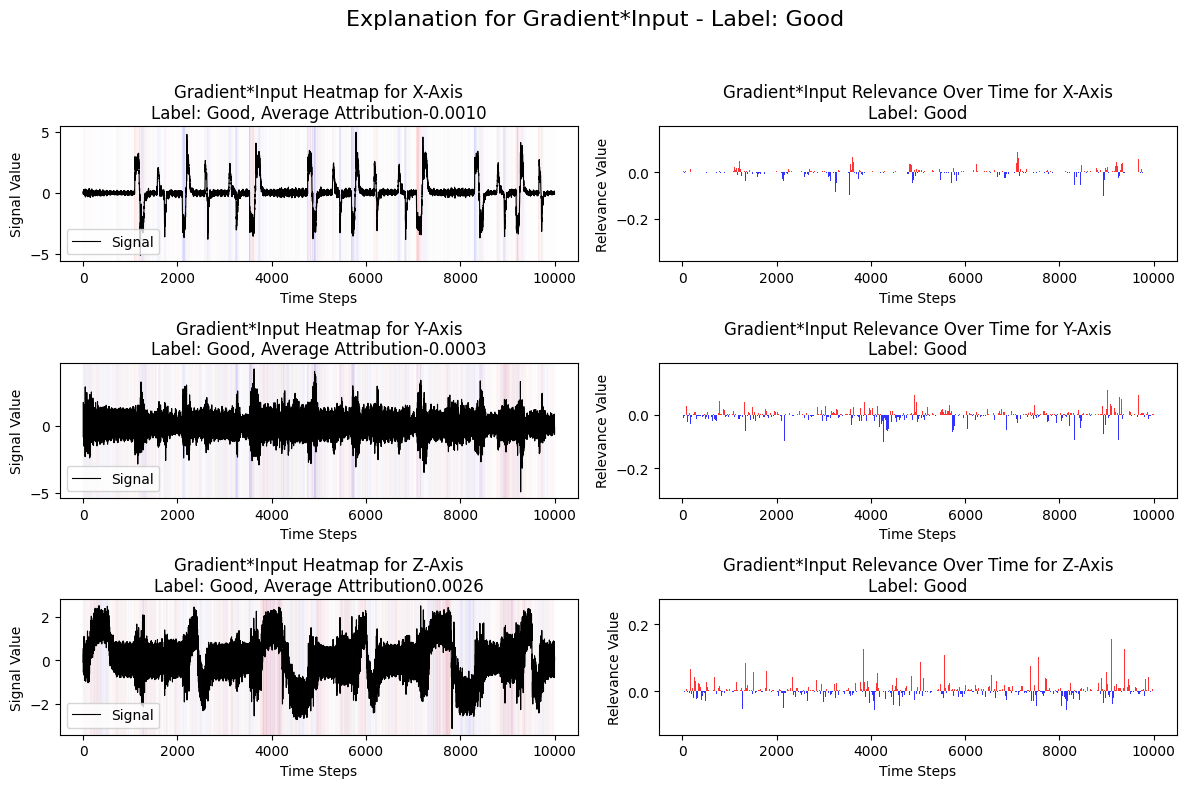

In [48]:

# Grad*Input
grad_input_attr, _ = xai_grad_times_input(model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [49]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            4715                 29.056210   
1  Axis 1            5021                 49.749332   
2  Axis 2            5143                 69.947632   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.006163            5285                -39.219425   
1                    0.009908            4979                -52.682781   
2                    0.013601            4857                -43.502792   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.007421                   -10.163216   
1                   -0.010581                    -2.933449   
2                   -0.008957                    26.444839   

   Average Relevance (Pos + Neg)  
0                      -0.001016  
1                      -0.000293  
2                       0.002644  


Min relevance: -0.02884666807949543, Max relevance: 0.06722740083932877
 Maximum Absolute Attribution in Axis 0: 0.05340081825852394
 Maximum Absolute Attribution in Axis 1: 0.06722740083932877
 Maximum Absolute Attribution in Axis 2: 0.02010602317750454


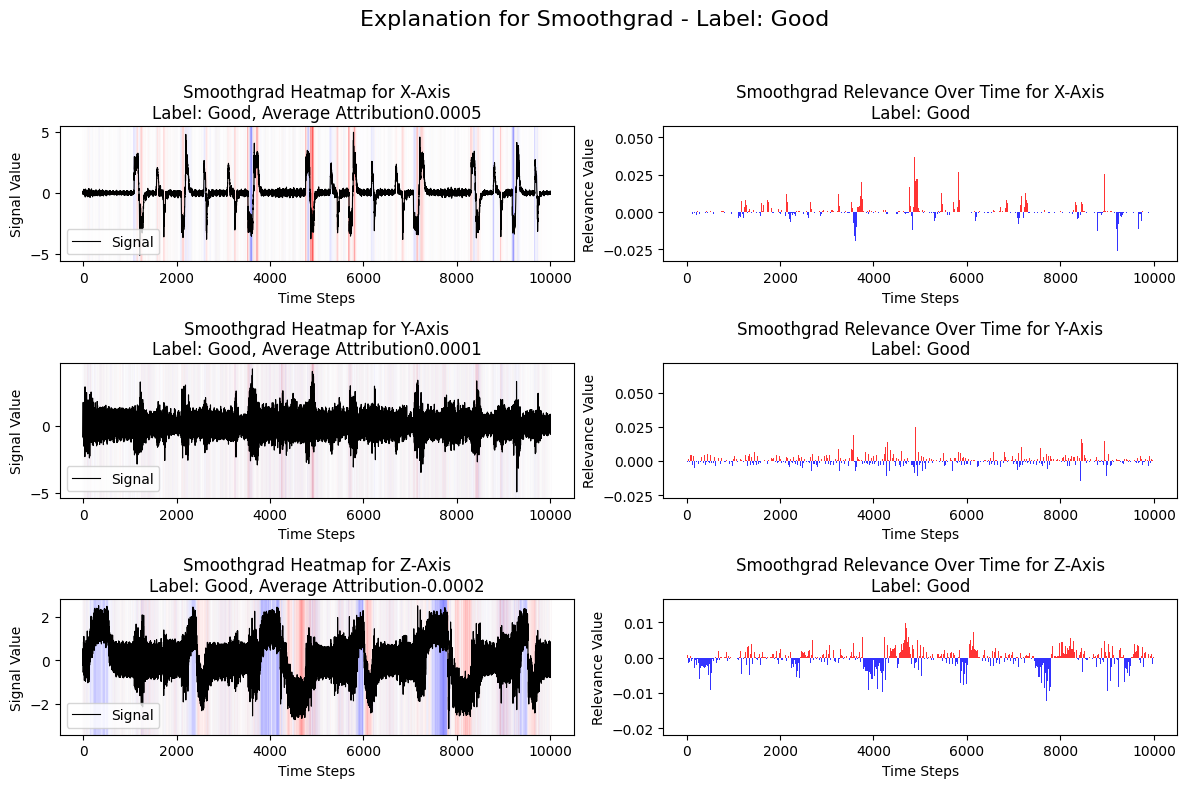

In [50]:
# SmoothGrad
smoothgrad_attr, _ = xai_smoothgrad(model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.021795272827148438, Max relevance: 0.02306365966796875
 Maximum Absolute Attribution in Axis 0: 0.017864227294921875
 Maximum Absolute Attribution in Axis 1: 0.021795272827148438
 Maximum Absolute Attribution in Axis 2: 0.02306365966796875


C:\Users\asadi\AppData\Local\Temp\ipykernel_22720\3560801465.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title


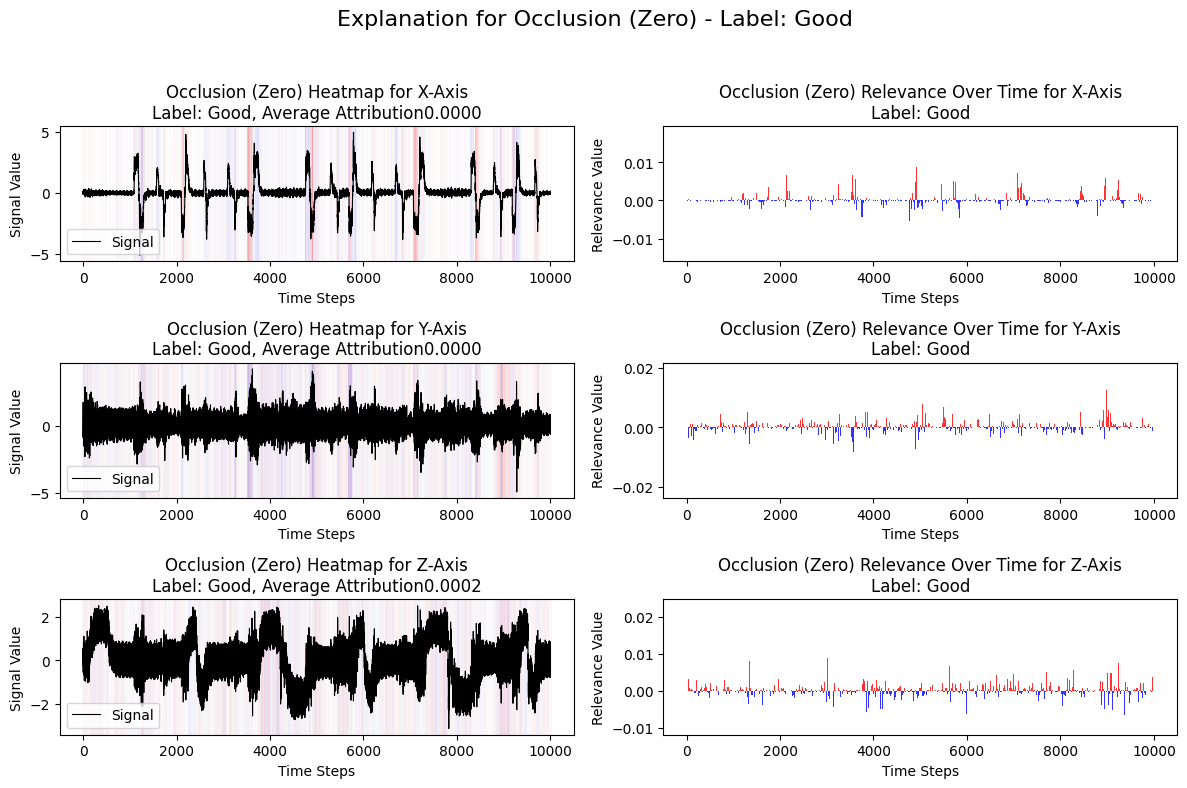

In [51]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = xai_occlusion_signal(model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.017709732055664062, Max relevance: 0.03168010711669922
 Maximum Absolute Attribution in Axis 0: 0.027261734008789062
 Maximum Absolute Attribution in Axis 1: 0.03168010711669922
 Maximum Absolute Attribution in Axis 2: 0.016809463500976562


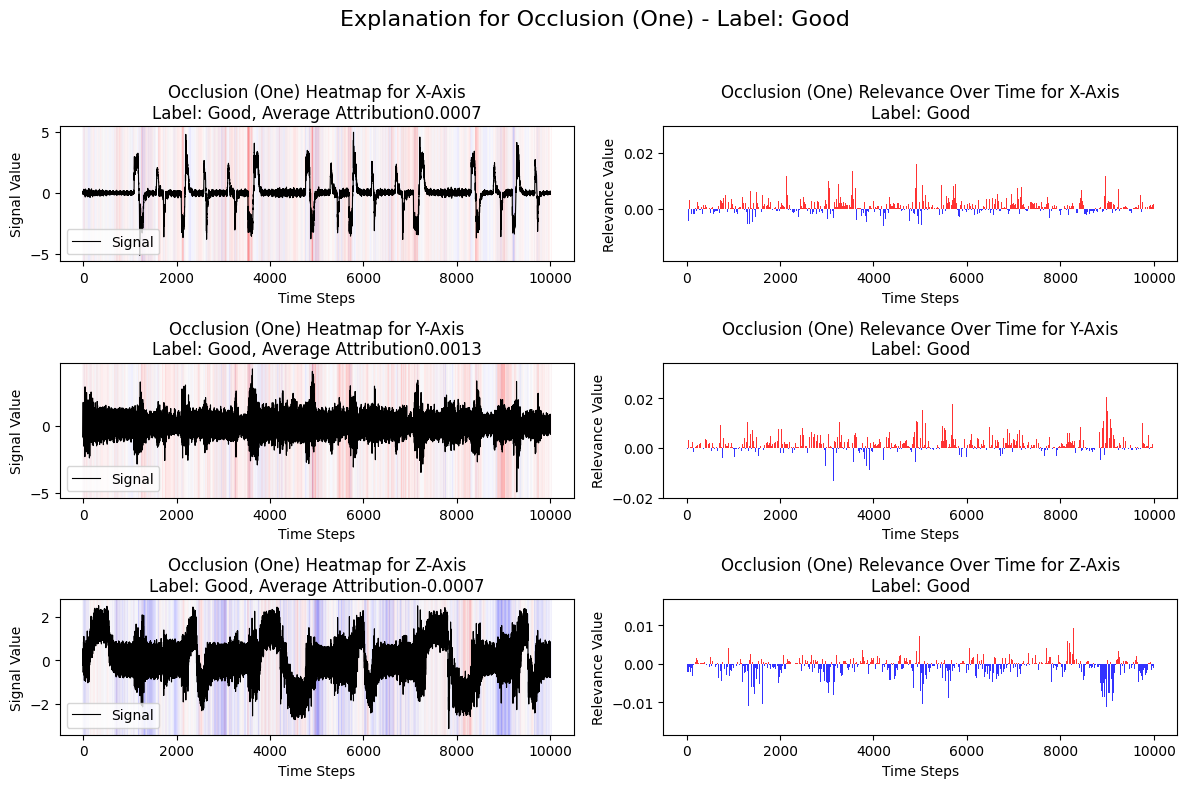

In [52]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = xai_occlusion_signal(model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.025272369384765625, Max relevance: 0.02841472625732422
 Maximum Absolute Attribution in Axis 0: 0.017763137817382812
 Maximum Absolute Attribution in Axis 1: 0.025272369384765625
 Maximum Absolute Attribution in Axis 2: 0.02841472625732422


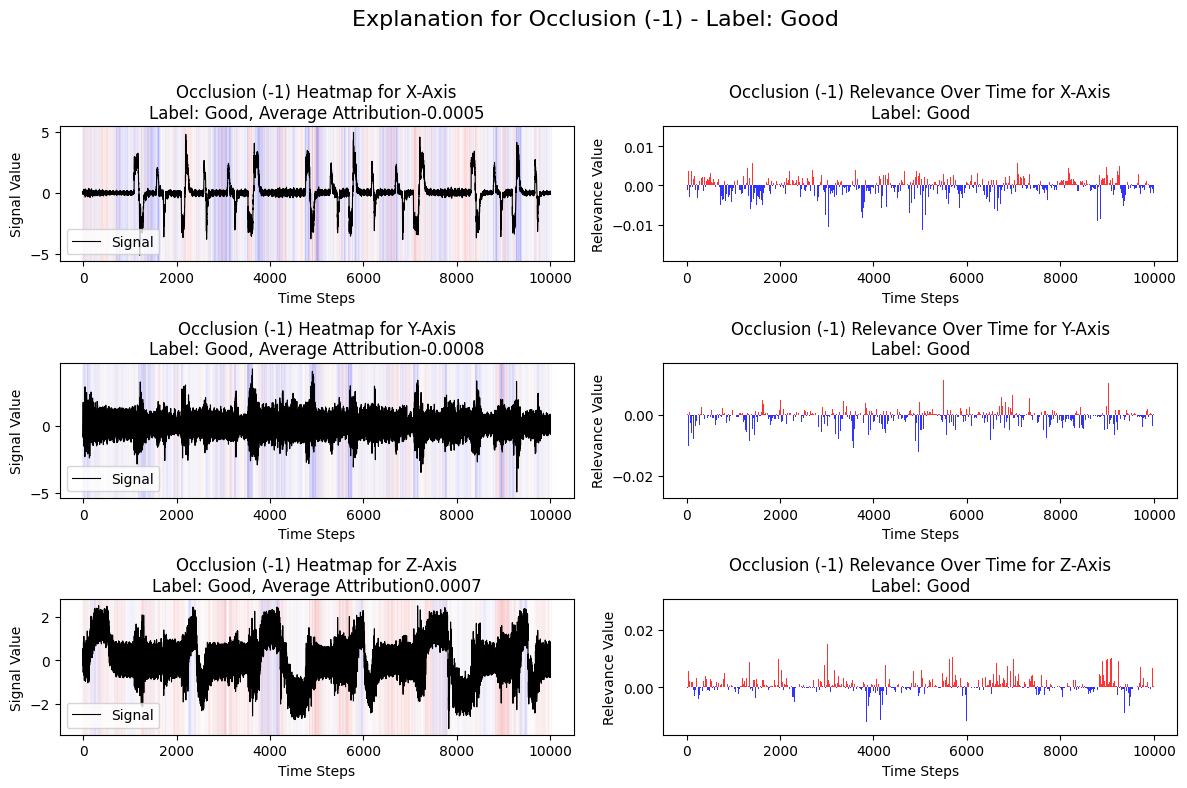

In [53]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = xai_occlusion_signal(model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.030065536499023438, Max relevance: 0.048836708068847656
 Maximum Absolute Attribution in Axis 0: 0.048836708068847656
 Maximum Absolute Attribution in Axis 1: 0.040602684020996094
 Maximum Absolute Attribution in Axis 2: 0.03256797790527344


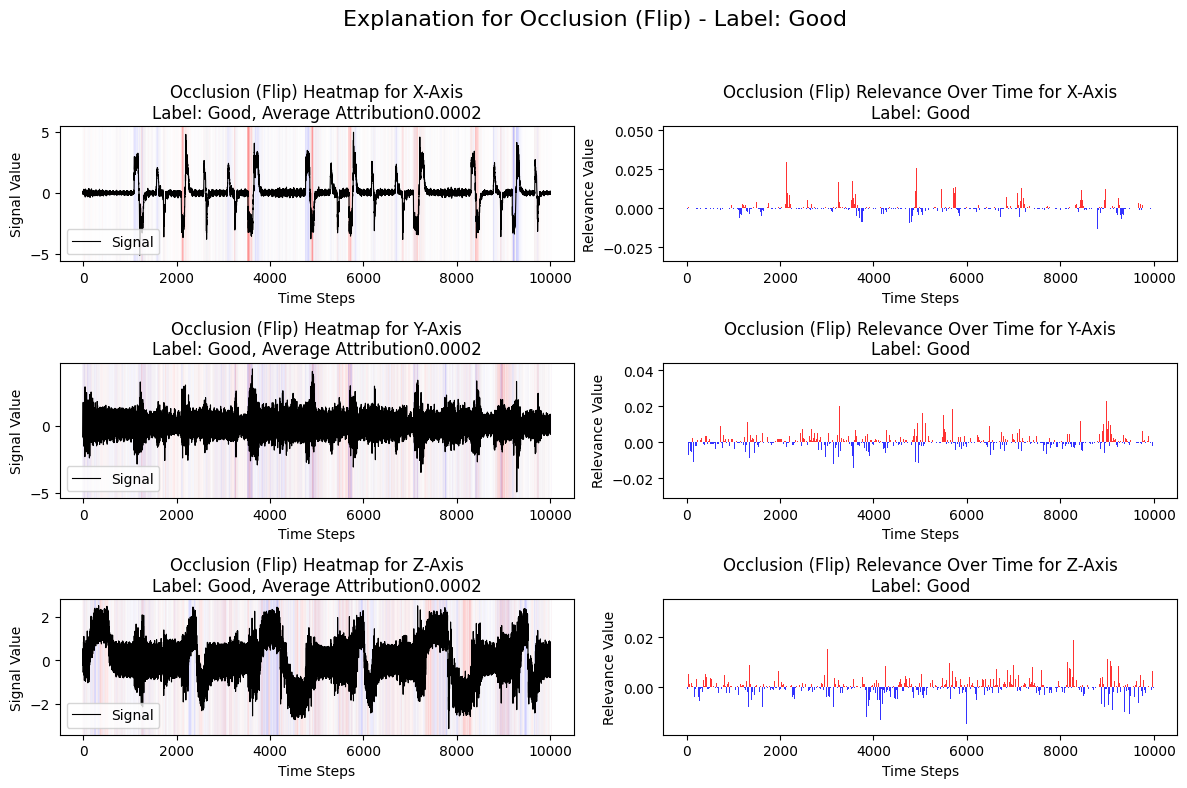

In [54]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = xai_occlusion_signal(model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_combined_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


Min relevance: -0.44103893637657166, Max relevance: 1.4402376413345337
 Maximum Absolute Attribution in Axis 0: 0.8710877299308777
 Maximum Absolute Attribution in Axis 1: 1.4402376413345337
 Maximum Absolute Attribution in Axis 2: 1.0422861576080322


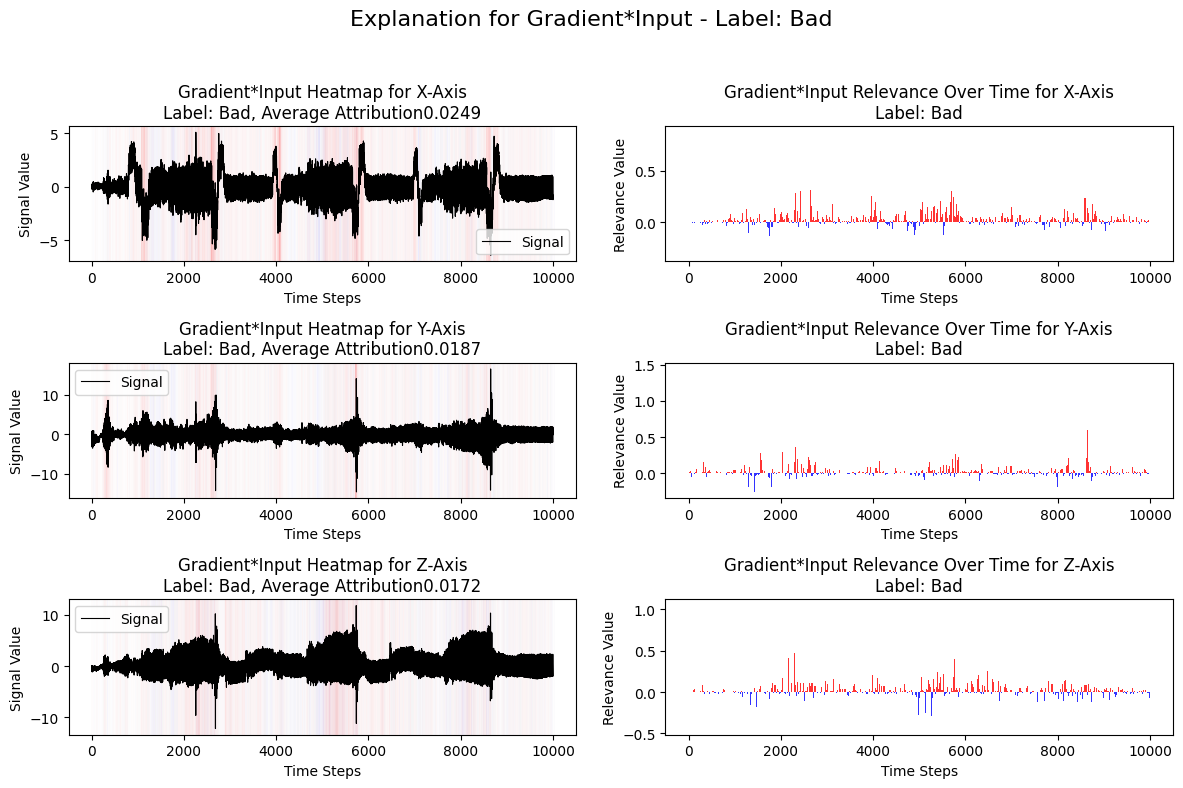

In [55]:
# Grad*Input
grad_input_attr_b, _ = xai_grad_times_input(model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [56]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            6533                309.922119   
1  Axis 1            6207                264.485962   
2  Axis 2            6000                274.285156   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.047439            3467                -60.744816   
1                    0.042611            3793                -77.358330   
2                    0.045714            4000               -102.777542   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.017521                   249.177307   
1                   -0.020395                   187.127625   
2                   -0.025694                   171.507614   

   Average Relevance (Pos + Neg)  
0                       0.024918  
1                       0.018713  
2                       0.017151  


Min relevance: -1.102223515510559, Max relevance: 5.290523052215576
 Maximum Absolute Attribution in Axis 0: 3.203758478164673
 Maximum Absolute Attribution in Axis 1: 5.290523052215576
 Maximum Absolute Attribution in Axis 2: 1.906677484512329


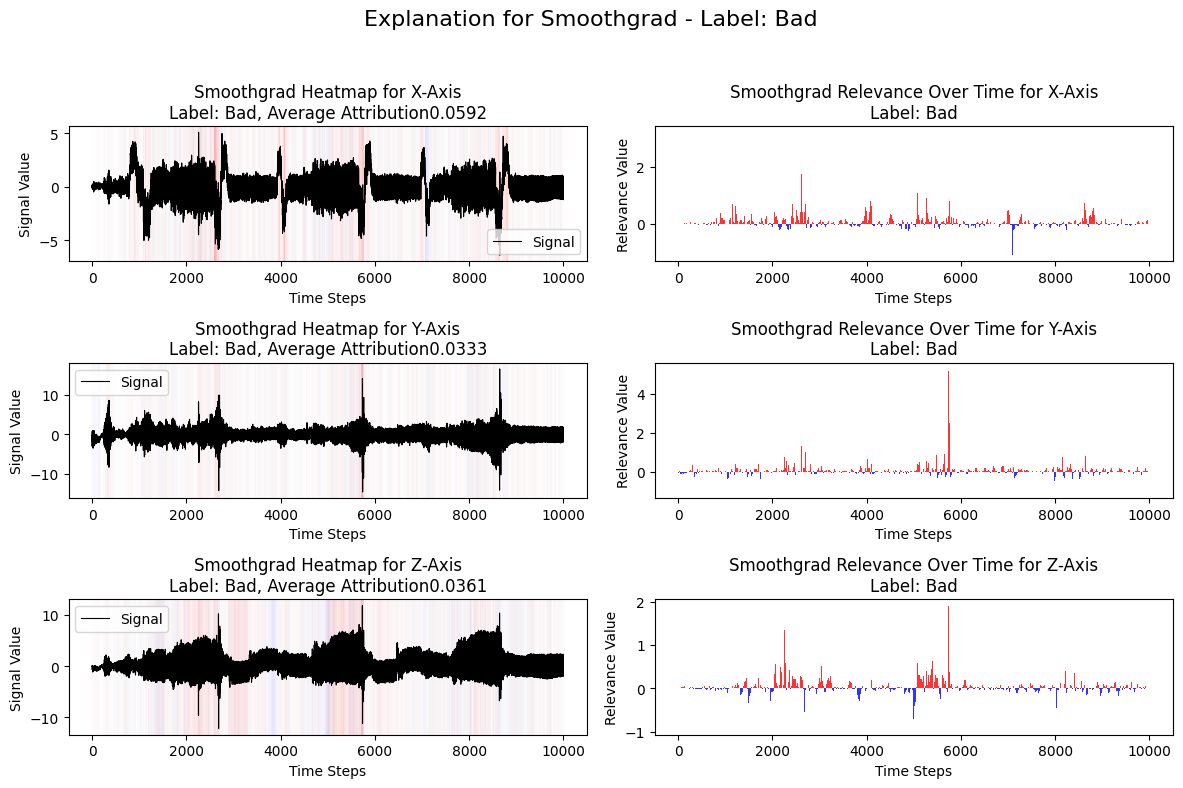

In [57]:
# SmoothGrad
smoothgrad_attr_b, _ = xai_smoothgrad(model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [58]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            6053                830.536133   
1  Axis 1            5675                638.797363   
2  Axis 2            6169                576.334290   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.137211            3947               -238.108124   
1                    0.112563            4325               -306.062653   
2                    0.093424            3831               -215.207642   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.060326                   592.427979   
1                   -0.070766                   332.734711   
2                   -0.056175                   361.126648   

   Average Relevance (Pos + Neg)  
0                       0.059243  
1                       0.033273  
2                       0.036113  


Min relevance: -0.031000137329101562, Max relevance: 0.04972076416015625
 Maximum Absolute Attribution in Axis 0: 0.040920257568359375
 Maximum Absolute Attribution in Axis 1: 0.04972076416015625
 Maximum Absolute Attribution in Axis 2: 0.031000137329101562


C:\Users\asadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


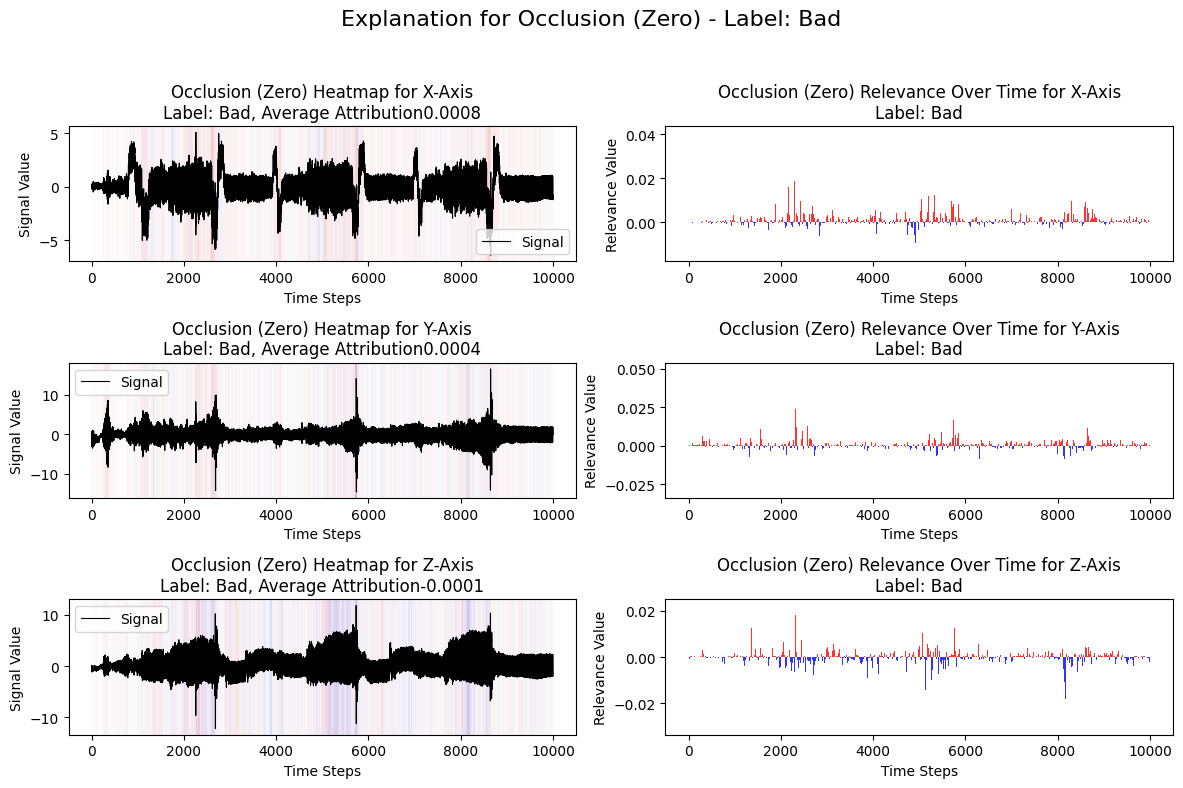

In [59]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.03658294677734375, Max relevance: 0.04837989807128906
 Maximum Absolute Attribution in Axis 0: 0.046344757080078125
 Maximum Absolute Attribution in Axis 1: 0.04837989807128906
 Maximum Absolute Attribution in Axis 2: 0.027395248413085938


C:\Users\asadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


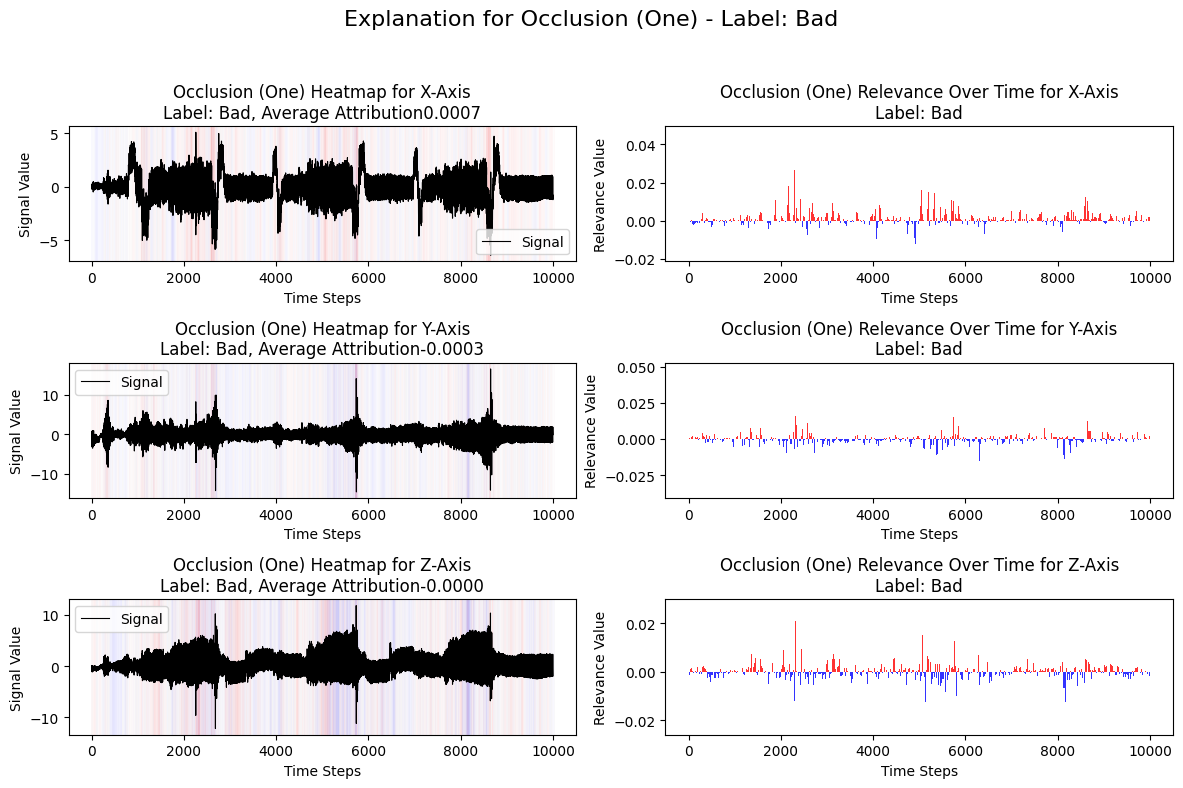

In [60]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.038532257080078125, Max relevance: 0.0508270263671875
 Maximum Absolute Attribution in Axis 0: 0.034893035888671875
 Maximum Absolute Attribution in Axis 1: 0.0508270263671875
 Maximum Absolute Attribution in Axis 2: 0.038532257080078125


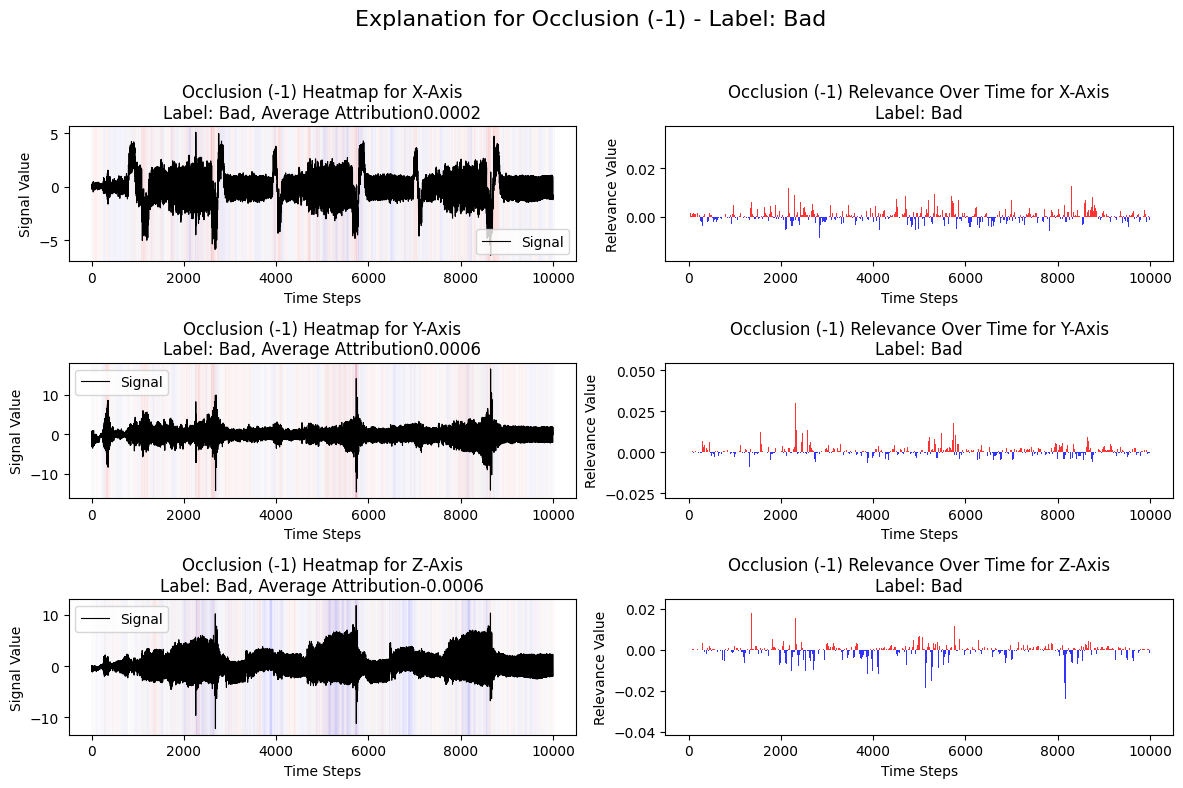

In [61]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.11755752563476562, Max relevance: 0.05170631408691406
 Maximum Absolute Attribution in Axis 0: 0.05170631408691406
 Maximum Absolute Attribution in Axis 1: 0.11755752563476562
 Maximum Absolute Attribution in Axis 2: 0.09861183166503906


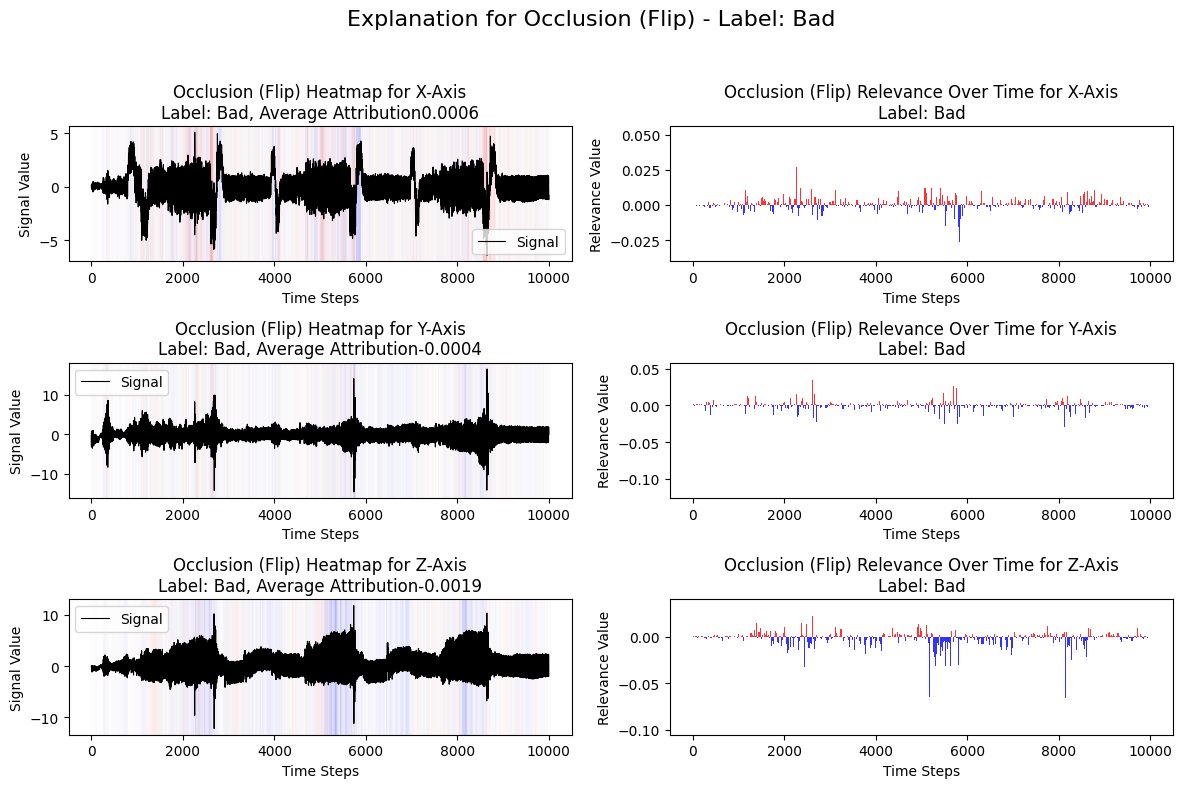

In [62]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_combined_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


In [63]:
# Apply LRP-Epsilon
lrp_attr_eps, _ = xai_lrp_zennit(model, sample, label, rule="eps")
print(f"Min relevance: {np.min(lrp_attr_eps.detach().cpu().numpy())}, Max relevance: {np.max(lrp_attr_eps.detach().cpu().numpy())}")

# Visualize the results
visualize_combined_with_label_attribution(sample, lrp_attr_eps, label, "LRP (epsilon)")



RuntimeError: you can only change requires_grad flags of leaf variables.

In [64]:
# Apply LRP-ZPlus
lrp_attr_zplus = xai_lrp_zennit(model, sample, label, rule="zplus")
print(f"Min relevance: {np.min(lrp_attr_zplus.detach().cpu().numpy())}, Max relevance: {np.max(lrp_attr_zplus.detach().cpu().numpy())}")

visualize_combined_with_label_attribution(sample_b, lrp_attr_zplus, label, "LRP (Zplus)")


RuntimeError: you can only change requires_grad flags of leaf variables.

In [66]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            5375                 15.612261   
1  Axis 1            4904                 12.367989   
2  Axis 2            4216                 10.839317   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.002905            4605                -10.006166   
1                    0.002522            5079                -16.138193   
2                    0.002571            5766                -30.098448   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002173                     5.606094   
1                   -0.003177                    -3.770205   
2                   -0.005220                   -19.259130   

   Average Relevance (Pos + Neg)  
0                       0.000562  
1                      -0.000378  
2                      -0.001929  
